In [1]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

print("All Imported")

All Imported


In [2]:
data_path = 'Datasets/'
train_path = 'Datasets/train/'
test_path = 'Datasets/test/'
val_path = 'Datasets/val/'

In [3]:
img_size = 200

In [4]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [5]:

train = read_data([train_path])
test = read_data([val_path, test_path])

C:\Users\91727\AppData\Local\Temp/ipykernel_5128/1485154423.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


In [6]:
# Shuffle the data

for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [7]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [8]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2       NORMAL
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

d:\sd_proj1\sdproj\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\sd_proj1\sdproj\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


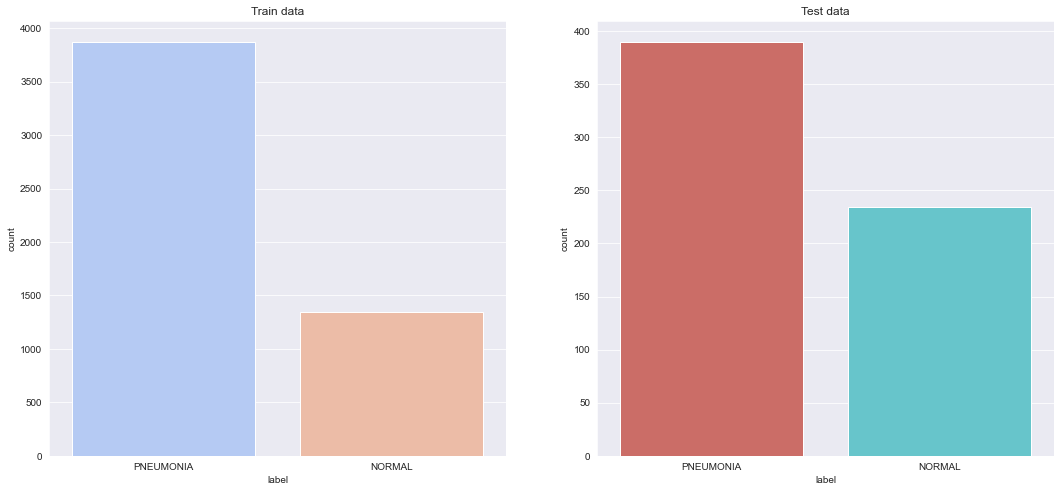

In [9]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

In [10]:
train_df.shape

(5216, 2)

In [11]:
test_df.shape


(624, 2)

Wall time: 438 ms


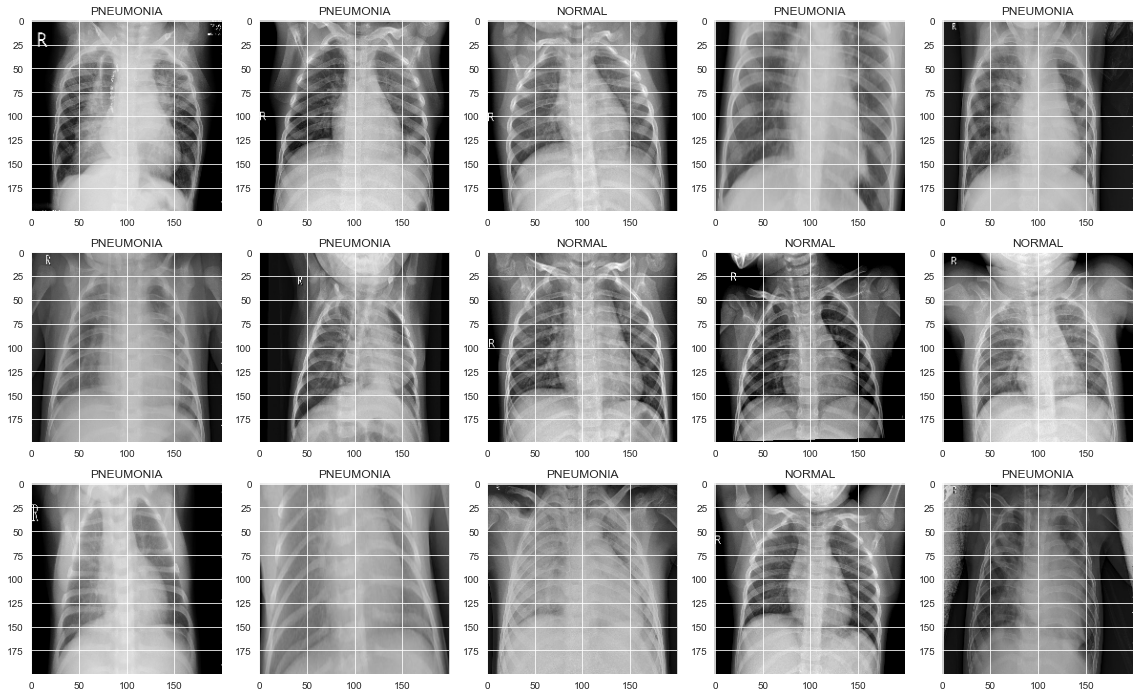

In [12]:
%%time

def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

In [13]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [14]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [15]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [16]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [17]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [18]:
num_classes = y_train.shape[1]
num_pixels = X_train.shape[1] 


In [19]:
input_shape = (img_size, img_size, 1)

In [20]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [21]:
num_pixels

200

In [22]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])



In [23]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      4

In [24]:
%%time

learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 20,
          verbose = 1,
          callbacks = callbacks3,
          validation_data = (X_test, y_test))


Epoch 1/20
82/82 [==============================] - 302s 4s/step - loss: 1.1542 - accuracy: 0.6867 - val_loss: 2.9181 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/20
82/82 [==============================] - 301s 4s/step - loss: 0.3328 - accuracy: 0.8681 - val_loss: 5.4488 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/20
82/82 [==============================] - 302s 4s/step - loss: 0.2111 - accuracy: 0.9231 - val_loss: 5.5251 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/20
82/82 [==============================] - 294s 4s/step - loss: 0.1539 - accuracy: 0.9477 - val_loss: 5.1392 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/20
82/82 [==============================] - 297s 4s/step - loss: 0.1503 - accuracy: 0.9461 - val_loss: 0.6906 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/20
82/82 [==============================] - 389s 5s/step - loss: 0.1598 - accuracy: 0.9406 - val_loss: 7.3429 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/20
82/82 [==============================] - 407s 5s/step - loss: 0.1

In [25]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 184.82178449630737%
Test accuracy: 77.24359035491943%
MLP Error: 22.76%


In [26]:
model.save('CNN_model.hdf5')